In [1]:
import sys
# sys.path.insert(0, '../../')
import rasterio
import numpy as np
from pathlib import Path
import rioxarray

In [2]:
import warnings
import time
import os

# RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
#     CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
#     GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
#     AWS_NO_SIGN_REQUEST="YES",
#     GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
#     GDAL_SWATH_SIZE="200000000",
#     VSI_CURL_CACHE_SIZE="200000000",
# )
# os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T

from rasterio.enums import Resampling

# import geopandas as gpd
# import dask_geopandas

# import pystac_client
# import planetary_computer as pc

import shapely.geometry

## Manually extract RGB and NIR patches around north berkeley

In [3]:
from shapely.geometry import Point
berkeley = Point(-122.24055786132824,37.90587960532352)

In [7]:


side_length = 50000
side_px=256
image_rgb = None
url_rgb = 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/S/EH/2019/11/21/S2B_MSIL2A_20191121T185659_N0212_R113_T10SEH_20201003T184646.SAFE/GRANULE/L2A_T10SEH_A014153_20191121T190140/IMG_DATA/R10m/T10SEH_20191121T185659_TCI_10m.tif?st=2022-12-03T22%3A25%3A40Z&se=2022-12-05T06%3A25%3A40Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-04T16%3A51%3A23Z&ske=2022-12-11T16%3A51%3A23Z&sks=b&skv=2021-06-08&sig=1qJnRk3oUi5Kl74ESQKu7DYCiRruPrzvWQAob6kpBGM%3D'
url_nir = 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/S/EH/2019/11/21/S2B_MSIL2A_20191121T185659_N0212_R113_T10SEH_20201003T184646.SAFE/GRANULE/L2A_T10SEH_A014153_20191121T190140/IMG_DATA/R10m/T10SEH_20191121T185659_B08_10m.tif?st=2022-12-03T22%3A25%3A40Z&se=2022-12-05T06%3A25%3A40Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-04T16%3A51%3A23Z&ske=2022-12-11T16%3A51%3A23Z&sks=b&skv=2021-06-08&sig=1qJnRk3oUi5Kl74ESQKu7DYCiRruPrzvWQAob6kpBGM%3D'
postprocess = T.Compose ([T.Resize(side_px), 
                         T.CenterCrop((side_px,side_px))])

to_pil = T.ToPILImage()

aoi_si = None
aspect_ratio = 1.

buf_perc = 0.1

with rasterio.Env():
    with rasterio.open(url_rgb, "r") as f:
        
        point_geom = rasterio.warp.transform_geom("epsg:4326", f.crs.to_string(), berkeley)
        print(f.crs.to_string())
        #Convert the point to a shape
        point_shape = shapely.geometry.shape(point_geom)
        #Create a square out of it with side_length = buffer*2
        radius = side_length/2 
        mask_shape = point_shape.buffer(radius).envelope
        mask_geom = shapely.geometry.mapping(mask_shape)
        
        # mask_gdf = gpd.GeoDataFrame(geometry=mask_geom, crs=f.crs.to_string())  
        # mask_gdf
        # mask_geom
        # rds = rioxarray.open_rasterio(f) #, masked=True)
        try:

            #Outer crop
            aoi_si = rioxarray.open_rasterio(f).rio.clip([mask_geom], from_disk=True)

            aspect_ratio = aoi_si.shape[2]/aoi_si.shape[1]

            new_height = side_px
            new_width = aspect_ratio * new_height
            
            print(new_height, new_width)

            #downsample raster                                    # (height, width)
            aoi_si = aoi_si.rio.reproject(aoi_si.rio.crs, shape=(int(new_height), int(new_width)), resampling=Resampling.bilinear)

            # image_rgb.sel(band=1).plot.imshow()
            # image_rgb.plot.imshow()
            print(aoi_si.shape)
            # image_rgb.plot.imshow()
            #Convert to torch
            # RGB
            # t = torch.from_numpy(aoi_si.values).float()
            
            ## NIR
            t = torch.from_numpy(aoi_si.values.astype(np.uint8))
            
            # postprocess = T.Compose ([T.CenterCrop((t.shape[1])),
            #                          T.Resize(side_px)])
            # t = T.CenterCrop(size=(t.shape[1]))(t)
            # t = T.Resize(size=side_px, antialias=True)(t)
            # display1 = to_pil(t)
            t = T.CenterCrop(size=(t.shape[1]))(t)
            display2 = to_pil(t)
            # t = F.resize(t, (1024,1024))
            # t = postprocess(t)
            #otherwise images dont display properly
            #but uint8 conversion has already taken care of this downresolution
            # t /= 255 
            print(t.shape, type(t))
#             #only for display
           
            # display1.show("Before CenterCrop")
            display2.show("After CenterCrop")
            
        except ValueError as e:
            print("Couldnt open URL ({:} or requested grid doesnt overlap)")


EPSG:32610
256 420.72165626026947
(3, 256, 420)
torch.Size([3, 256, 256]) <class 'torch.Tensor'>


### Save to disk 

For future experiements without having to read from cloud or generating URLs(they expire)

In [3]:
aoi_si.rio.to_raster("berkeley.tif")

NameError: name 'aoi_si' is not defined

### Read from disk

In [4]:
aoi_si = rioxarray.open_rasterio("berkeley.tif")
aoi_si.rio.crs, aoi_si.rio.bounds

(CRS.from_epsg(32610),
 <bound method XRasterBase.bounds of <rioxarray.raster_array.RasterArray object at 0x156865b20>>)

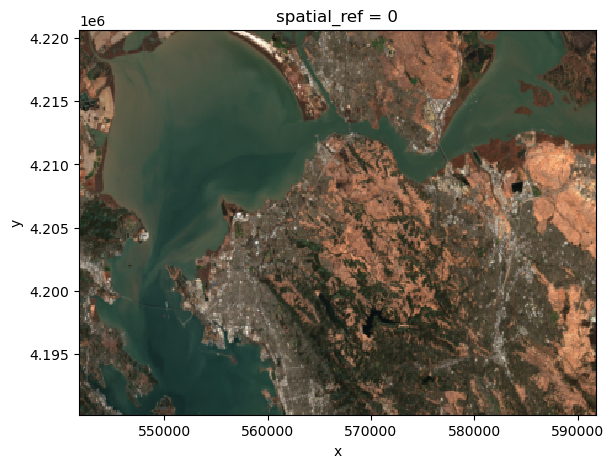

In [5]:
aoi_si.plot.imshow(size=5)#, aspect=aspect_ratio)

In [6]:
aoi_si.rio.resolution(), aoi_si.rio.height,  aoi_si.values.shape, aoi_si.rio.crs

((119.07142857142846, -118.8671875), 256, (3, 256, 420), CRS.from_epsg(32610))

In [7]:
aoi_si

<xarray.DataArray (band: 3, y: 256, x: 420)>
array([[[ 72,  63, ...,  41,  32],
        [ 66,  71, ...,  33,  28],
        ...,
        [ 68,  46, ..., 109,  76],
        [ 60,  53, ..., 159,  72]],

       [[ 68,  51, ...,  33,  27],
        [ 57,  57, ...,  29,  25],
        ...,
        [ 57,  45, ...,  78,  58],
        [ 54,  50, ..., 108,  53]],

       [[ 51,  39, ...,  28,  24],
        [ 43,  43, ...,  25,  22],
        ...,
        [ 45,  35, ...,  57,  41],
        [ 41,  38, ...,  80,  38]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.418e+05 5.419e+05 ... 5.916e+05 5.917e+05
  * y            (y) float64 4.221e+06 4.22e+06 4.22e+06 ... 4.19e+06 4.19e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

## Open a single env raster to match with

## Let's try to open, crop and reproject ENV raster in one shot

### Pre-crop to reduce compute time during reproject_match

In [10]:
%%time

import shapely.geometry

dst_crs = 'epsg:32610'
side_len_m = 50000
side_len = side_len_m / (111.11 * 1000)
buf = 0.1 # to take care of warping issues
berkeley = (-122.240558, 37.90588)
point_geom = shapely.geometry.mapping(shapely.geometry.Point(berkeley))
env_raster = None

# Grid points are in 4326 -> move to 32610
# point_geom = rasterio.warp.transform_geom("epsg:4326", dst_crs, point_geom)
# point_geom = rasterio.warp.transform_geom(self.crs, dst_crs, point_geom)

#Convert the point to a shape
point_shape = shapely.geometry.shape(point_geom)
#Create a square out of it with side_length = buffer*2
mask_shape = point_shape.buffer(side_len * (1+buf)).envelope
# mask_shape = point_shape.buffer(0.025).envelope
mask_geom = shapely.geometry.mapping(mask_shape)
mask_geom

local_path = "bio_11_USA.tif"
s3_raster_path = "s3://datasets-sdm/geoLifeCLEF/rasters/bdticm/bdticm_USA.tif"
s3_raster_path = "s3://datasets-sdm/geoLifeCLEF/rasters/cecsol/cecsol_USA.tif"
env_raster = None

with rasterio.Env():
    with rasterio.open(s3_raster_path, "r") as f:
            # rds = rioxarray.open_rasterio(f, bbox=mask_geom['coordinates'], crop=True)
            env_raster = rioxarray.open_rasterio(f,masked=True)

            
            
# cropped_env_raster


CPU times: user 12.5 ms, sys: 5.19 ms, total: 17.7 ms
Wall time: 15.3 ms


In [11]:
%%time 
cropped_env_raster = env_raster.rio.clip([mask_geom], from_disk=True).rio.reproject_match(aoi_si,resampling=Resampling.bilinear)
# cropped_env_raster = env_raster.rio.reproject_match(aoi_si,resampling=Resampling.bilinear)


CPU times: user 81.4 ms, sys: 9.31 ms, total: 90.7 ms
Wall time: 88.8 ms


In [41]:
import gc
cropped_env_raster = None
env_raster = None
gc.collect()

7066

In [13]:
%%time
to_pil = T.ToPILImage()

t_env = torch.from_numpy(cropped_env_raster.values.astype(np.uint8))
t_env = T.CenterCrop(size=(t_env.shape[1]))(t_env)
display1 = to_pil(t_env)

print(t_env.shape, type(t_env), cropped_env_raster.rio.crs)

torch.Size([1, 256, 256]) <class 'torch.Tensor'> EPSG:32610
CPU times: user 4.54 ms, sys: 3.24 ms, total: 7.78 ms
Wall time: 7.17 ms


In [14]:
display1 = to_pil(t_env)
# display1.show("After CenterCrop")
display1.save("env_raster.png")

In [109]:
import gc
del cropped_env_raster
gc.collect()

147

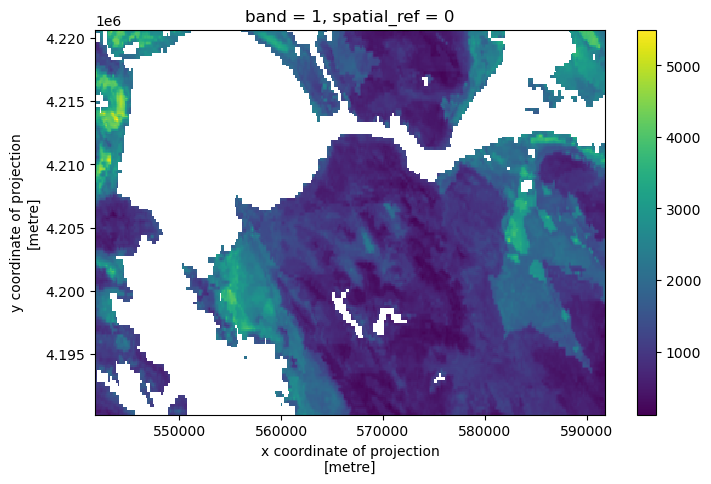

In [36]:
cropped_env_raster[0].plot.imshow(size=5,aspect=aspect_ratio)

## Same, but with Patch Extractor

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from environmental_raster import PatchExtractor

In [4]:
env_extractor = PatchExtractor(s3_path, side_len_m=50000, side_px=512, out_dtype="float")

NameError: name 's3_path' is not defined